<a href="https://colab.research.google.com/github/AbdKhuffash/Advanced-Image-Classification-with-Transfer-Learning-using-PyTorch/blob/main/Advanced_Image_Classification_with_Transfer_Learning_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Image Classification with Transfer Learning using PyTorch
This case study demonstrates the use of transfer learning to classify images from the CIFAR-10 dataset using pre-trained AlexNet and VGG16 models.

The steps involved in this case study include:
---
## Setup and Data Preparation

*   Load the CIFAR-10 dataset and apply transformations.
*   Define the training and evaluation functions.
*   Use DataLoader for batch processing.

---

## Load and Adapt Pre-trained Models

*   Load the pre-trained AlexNet and VGG16 models, modifying them for CIFAR-10 classification.
*   Fine-tune some models by unfreezing the last layers, while others are used as fixed feature extractors.

---

## Compile and Train the Models

*   Define loss functions and optimizers.
*   Train the models using the training data.
*   Save the training history.

---

## Evaluate the Models


*   Evaluate the models' performance on the test dataset.
*   Plot the training and validation accuracy and loss over epochs.









# Step 1: Setup and Data Preparation

Importing Needed Libraries:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


This code prepares the data and environment for training a neural network on the CIFAR-10 dataset using PyTorch:

In [2]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define transformations for the training and test sets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 29464099.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



---
---
The transformation transforms.RandomCrop(32, padding=4) is a part of the data augmentation process used to enhance the diversity of the training dataset.

The primary purpose of transforms.RandomCrop is to randomly crop the images to a specified size. This helps in making the model more robust by training it on slightly different versions of the same image.

32: This is the size of the crop. The transformation will crop the images to 32x32 pixels.

padding=4: Before performing the crop, the transformation pads the image with 4 pixels on each side. Padding is added to ensure that the cropped area can include regions near the edges of the original image.

---
---
The numbers ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) in the code refer to the mean and standard deviation values used for normalizing the CIFAR-10 dataset.

Normalization is a common preprocessing step in training machine learning models, especially for image data. It helps to standardize the range of the input data, which can lead to faster convergence during training and can also improve the overall performance of the model.

**Why Normalize?**

Normalization involves adjusting the values in the dataset to have a mean of 0 and a standard deviation of 1 (or other chosen values). For image data, this is typically done per color channel. The specific mean and standard deviation values used here are calculated from the CIFAR-10 training dataset and are applied to every image in both the training and test datasets.

*How It Works*

For each image pixel value, normalization is done as follows:

Normalized pixel value= (Originalpixelvalue-Mean)/StandaredDeviation

This formula is applied to each channel (Red, Green, Blue) of the image. The mean and standard deviation are used to scale the pixel values so that they have the same distribution properties across the entire dataset.

*Example*

Let's take an example pixel with RGB values (R=125, G=130, B=115) and apply normalization:

1.   For the Red channel:

      Normalized Red=(125-0.4914)/.2023
2.   For the Green channel:

      Normalized Green=(130-.4822)/.1994
3.   For the Blue channel:

      Normalized Blue= (115-.4465)/.2010

Applying these operations helps ensure that each input image contributes equally during training, without some images dominating due to higher pixel intensity values. This leads to more stable and effective training of the neural network model.

---
---

# Step 2: Load and Adapt Pre-trained Models

This code essentially sets up two models (AlexNet and VGG16) in two configurations each: one where the entire model is fine-tuned, and one where only the final classifier layer is trained while the feature extraction layers are frozen. The modifications made to the layers ensure that the models are compatible with the CIFAR-10 dataset, which has 10 classes.

In [3]:
# Load pre-trained AlexNet and modify the classifier
alexnet = models.alexnet(pretrained=True)
alexnet.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
alexnet.features[2] = nn.MaxPool2d(kernel_size=2, stride=2)
alexnet.classifier[6] = nn.Linear(4096, 10)
alexnet = alexnet.to(device)

# Load pre-trained AlexNet and freeze all layers except the final layer
alexnet_fixed = models.alexnet(pretrained=True)
alexnet_fixed.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
alexnet_fixed.features[2] = nn.MaxPool2d(kernel_size=2, stride=2)
for param in alexnet_fixed.parameters():
    param.requires_grad = False
alexnet_fixed.classifier[6] = nn.Linear(4096, 10)
alexnet_fixed = alexnet_fixed.to(device)
optimizer_alexnet_fixed = optim.SGD(alexnet_fixed.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Load pre-trained VGG16 and modify the classifier
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16 = vgg16.to(device)
optimizer_vgg16 = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Load pre-trained VGG16 and freeze all layers except the final layer
vgg16_fixed = models.vgg16(pretrained=True)
for param in vgg16_fixed.parameters():
    param.requires_grad = False
vgg16_fixed.classifier[6] = nn.Linear(4096, 10)
vgg16_fixed = vgg16_fixed.to(device)
optimizer_vgg16_fixed = optim.SGD(vgg16_fixed.classifier[6].parameters(), lr=0.001, momentum=0.9)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 170MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed


---
---
1.   *Loading Pre-trained Models*

The models are loaded with pre-trained weights from large datasets (e.g., ImageNet). Pre-trained models provide a good starting point for many tasks since they have already learned useful features from a large and diverse dataset.

2.   *Modifying AlexNet*

  a.Modify Layers:


  *   Convolutional Layer: The first convolutional layer is modified to have a smaller kernel size and different padding/stride settings.
  *   Pooling Layer: The second layer is changed to a MaxPooling layer with a kernel size and stride of 2.

  b.Change Classifier:

  *   The last fully connected layer (classifier) is modified to output 10 classes instead of the original number of classes (typically 1000 for ImageNet).

  c.Move Model to Device:


  *   The model is moved to the specified device.


3.   *Freezing Layers*

In one version of AlexNet, all layers except the final classifier layer are frozen. This means that their weights will not be updated during training.

4.   *Optimizers*

Optimizers are set up for training the models. The learning rate and momentum are specified.


*   For the unfrozen AlexNet:

```
optimizer_alexnet = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
```

*   For the frozen AlexNet (only the classifier layer's parameters are optimized):

```
optimizer_alexnet_fixed = optim.SGD(alexnet_fixed.classifier[6].parameters(), lr=0.001, momentum=0.9)

```

5. *Modifying VGG16*

The process is similar to AlexNet.

  a. Change Classifier
  ```
  vgg16.classifier[6] = nn.Linear(4096, 10)
  vgg16 = vgg16.to(device)
  ```
  b. Optimizers

*   For the unfrozen VGG16:
```
optimizer_vgg16 = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
```

*   For the frozen VGG16 (only the classifier layer's parameters are optimized):
```
for param in vgg16_fixed.parameters():
      param.requires_grad = False
vgg16_fixed.classifier[6] = nn.Linear(4096, 10)
vgg16_fixed = vgg16_fixed.to(device)
optimizer_vgg16_fixed = optim.SGD(vgg16_fixed.classifier[6].parameters(), lr=0.001, momentum=0.9)
```








---
---

In [4]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_alexnet = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

---
---
1. Loss Function

  *   CrossEntropyLoss: This is a commonly used loss function for classification problems. It combines nn.LogSoftmax() and nn.NLLLoss() (negative log likelihood loss) in one single class.
  *   Purpose: The loss function measures the difference between the predicted class probabilities (from the model) and the actual class labels (ground truth). It penalizes the model more when it is more confident about incorrect predictions.
  *   Usage: For a multi-class classification task where the classes are mutually exclusive, nn.CrossEntropyLoss is appropriate.


2. Optimizer

* SGD (Stochastic Gradient Descent): This is an optimization algorithm used to minimize the loss function by updating the model parameters in the direction that reduces the loss.
  * Parameters: alexnet.parameters() are the weights of the model that need to be updated during training.
  * Learning Rate (lr): This is a hyperparameter that determines the step size at each iteration while moving toward a minimum of the loss function. A smaller learning rate means the model updates the weights slowly, which can lead to more stable convergence.
  * Momentum: This is a hyperparameter that helps accelerate the gradients vectors in the right direction, thus leading to faster converging. It helps in smoothing out the updates, dampening the oscillations, and avoiding local minima.

  **Putting It All Together**

* Loss Function: nn.CrossEntropyLoss will be used to compute the difference between the predicted outputs of the model and the actual labels during training. This loss guides how the model parameters should be adjusted.

* Optimizer: optim.SGD will use the gradients computed during backpropagation to update the model parameters. The momentum term helps in speeding up the training and stabilizing the convergence.

**Workflow During Training**

1. Forward Pass: Pass the input data through the model to get predictions.

2. Compute Loss: Use criterion (cross-entropy loss) to compute the difference between predictions and actual labels.

3. Backward Pass: Compute the gradients of the loss with respect to the model parameters.

4. Update Parameters: Use optimizer (SGD) to update the model parameters using the computed gradients.

---
---


# Step 3: Train the Models

The train function  is responsible for training a neural network model (model) on a dataset (trainloader) for a specified number of epochs (epochs=3).

In [5]:
# Training function
def train(model, optimizer, criterion, trainloader, device, epochs=3):
    model.train()
    training_loss = []
    accuracy = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        training_loss.append(epoch_loss)
        accuracy.append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%')

    return training_loss, accuracy

---
---
**Training Loop:**

* Outer Loop (epochs): Iterates over each epoch.
* Initialization for Each Epoch
```
running_loss = 0.0  # Accumulates the running loss for the epoch
correct = 0  # Counts the number of correctly predicted samples
total = 0  # Total number of samples processed in the epoch
```

* Inner Loop (trainloader): Iterates over batches of data from trainloader. contains (Data Preparation,Zero Gradient Accumulation,Forward Pass,Compute Loss,Backward Pass,Update Parameters,Metrics Calculation)

* Epoch Metrics:
```
epoch_loss = running_loss / len(trainloader)  # Compute average loss for the epoch
epoch_accuracy = 100 * correct / total  # Compute accuracy for the epoch
training_loss.append(epoch_loss)  # Append epoch loss to the training loss list
accuracy.append(epoch_accuracy)  # Append epoch accuracy to the accuracy list
print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%')  # Print epoch statistics
```


---
---

Several deep learning models are trained and evaluated on the CIFAR-10 dataset using the train function defined earlier.

In [6]:
# Train and evaluate AlexNet
print("Training finetuned AlexNet...")
loss_alexnet, acc_alexnet = train(alexnet, optimizer_alexnet, criterion, trainloader, device, epochs=3)


# Train and evaluate AlexNet with fixed feature extractor
print("Training AlexNet as fixed feature extractor...")
loss_alexnet_fixed, acc_alexnet_fixed = train(alexnet_fixed, optimizer_alexnet_fixed, criterion, trainloader, device, epochs=3)

# Train and evaluate VGG16
print("Training finetuned VGG16...")
loss_vgg16, acc_vgg16 = train(vgg16, optimizer_vgg16, criterion, trainloader, device, epochs=3)


# Train and evaluate VGG16 with fixed feature extractor
print("Training VGG16 as fixed feature extractor...")
loss_vgg16_fixed, acc_vgg16_fixed = train(vgg16_fixed, optimizer_vgg16_fixed, criterion, trainloader, device, epochs=3)



Training finetuned AlexNet...
Epoch 1, Loss: 1.4716850741506005, Accuracy: 46.598%
Epoch 2, Loss: 1.1074508950257256, Accuracy: 60.96%
Epoch 3, Loss: 0.9274564643967861, Accuracy: 67.368%
Training AlexNet as fixed feature extractor...
Epoch 1, Loss: 1.870542918423087, Accuracy: 31.6%
Epoch 2, Loss: 1.812548787259781, Accuracy: 34.352%
Epoch 3, Loss: 1.7994366886519653, Accuracy: 34.742%
Training finetuned VGG16...
Epoch 1, Loss: 0.8177716632874745, Accuracy: 71.998%
Epoch 2, Loss: 0.5216607592871231, Accuracy: 82.618%
Epoch 3, Loss: 0.42742011485643977, Accuracy: 85.414%
Training VGG16 as fixed feature extractor...
Epoch 1, Loss: 2.041646374812587, Accuracy: 41.98%
Epoch 2, Loss: 2.1064987787434633, Accuracy: 43.204%
Epoch 3, Loss: 2.141000798476177, Accuracy: 43.5%


---
---
The results presented are from training and evaluating two different models (AlexNet and VGG16) on the CIFAR-10 dataset under two different conditions: fine-tuned and with fixed feature extractor. Here's an explanation of each:

1. Fine-tuned AlexNet
  * Training finetuned AlexNet
    * Epoch 1: (Loss: 1.433 , Accuracy: 46.74%)
    * Epoch 2: (Loss: 1.057 ,Accuracy: 60.38%)
    * Epoch 3: (Loss: 0.889 ,Accuracy: 67.41%)

*Explanation:*
* Loss: Represents the average loss per batch over the entire training dataset for each epoch. Lower values indicate that the model's predictions are closer to the actual labels.
* Accuracy: Percentage of correctly predicted labels over the entire training dataset for each epoch. Higher values indicate better performance.

For the fine-tuned AlexNet, we observe that both the loss and accuracy improve significantly over each epoch. This suggests that adjusting the initial layers and the classifier of AlexNet allows it to learn features specific to the CIFAR-10 dataset, leading to better classification performance.

2. AlexNet with Fixed Feature Extractor
  * Training AlexNet as fixed feature extractor
    
    * Epoch 1: (Loss: 1.931 , Accuracy: 31.88%)
    * Epoch 2: (Loss: 1.884 , Accuracy: 34.70%)
    * Epoch 3: (Loss: 1.869 , Accuracy: 34.23%)
*Explanation:*

Here, AlexNet's convolutional layers are frozen, and only the classifier is trained. This results in lower accuracy and higher loss compared to the fine-tuned AlexNet. The model struggles to adapt to the CIFAR-10 dataset's nuances without modifying its initial layers, hence the poorer performance.

3. Fine-tuned VGG16
  * Training finetuned VGG16

    * Epoch 1:(Loss: 0.805 ,Accuracy: 71.59%)
    * Epoch 2:(Loss: 0.512 ,Accuracy: 82.75%)
    * Epoch 3:(Loss: 0.421 ,Accuracy: 85.88%)
*Explanation*

VGG16, when fine-tuned, shows excellent performance with a significant decrease in loss and increase in accuracy over each epoch. Its deeper architecture and effective feature learning capabilities allow it to achieve high accuracy on CIFAR-10.

4. VGG16 with Fixed Feature Extractor
  * Training VGG16 as fixed feature extractor

    * Epoch 1: (Loss: 2.053, Accuracy: 41.51%)
    * Epoch 2: (Loss: 2.145, Accuracy: 43.92%)
    * Epoch 3: (Loss: 2.138, Accuracy: 43.62%)

*Explanation:*

Similar to AlexNet, freezing VGG16's convolutional layers and training only the classifier results in lower accuracy and higher loss compared to fine-tuning. VGG16's complex architecture benefits greatly from fine-tuning, and freezing the initial layers hampers its ability to learn effectively for the CIFAR-10 dataset.


**Summary:**

* Fine-tuning (modifying initial layers and classifier) generally leads to better performance as seen in both AlexNet and VGG16.

* Freezing convolutional layers while training only the classifier (fixed feature extractor) results in inferior performance due to the inability to adapt to dataset-specific features effectively.


---
---



# Step 4: Evaluate the Models

The provided code includes two functions: evaluate and plot_curves, which are crucial for evaluating model performance and visualizing training metrics.

In [7]:
# Evaluation function
def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    return accuracy

# Function to plot accuracy and loss
def plot_curves(accuracy_dict, loss_dict):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for model_name, acc in accuracy_dict.items():
        plt.plot(acc, label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curves')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for model_name, loss in loss_dict.items():
        plt.plot(loss, label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.show()

---
---
1. Evaluation Function (evaluate):
 * Purpose: This function evaluates the performance of a given model on a specified testloader, computing its accuracy on a dataset.
 * Steps:

    * Set Evaluation Mode: model.eval() ensures the model behaves differently during evaluation (e.g., disables dropout).

    * Iterate Over Testloader: Processes batches of data (inputs and labels) from testloader.

    * Forward Pass: Computes predictions (outputs) using the model.

    * Accuracy Calculation: Compares predicted labels (predicted) with ground truth labels (labels) to determine the number of correctly classified samples (correct).

    * Accuracy: Computes and prints the accuracy as a percentage.

    * Return Value: Returns the accuracy value for further analysis or logging.

2. Plotting Function (plot_curves):
  * Purpose: This function visualizes training metrics (accuracy and loss) across epochs for different models.

  * Steps:

    * Figure Initialization: Creates a new figure with specified dimensions (12x5 inches).

    * Accuracy Plotting:
      * Uses accuracy_dict to iterate over model names and their corresponding accuracy lists (acc).
      * Plots accuracy curves for each model (acc) against epochs.
      * Labels axes, adds a title, and displays a legend.

    * Loss Plotting:
      * Uses loss_dict to iterate over model names and their corresponding loss lists (loss).
      * Plots loss curves for each model (loss) against epochs.
      * Labels axes, adds a title, and displays a legend.

    * Display: Shows the plots using plt.show().


**Summary:**

* Evaluation Function: evaluate computes and prints the accuracy of a model on a test dataset, crucial for assessing model performance after training.

* Plotting Function: plot_curves visualizes training metrics (accuracy and loss) across epochs for multiple models, aiding in comparative analysis and performance visualization.



---
---

In [10]:
# Dictionary to store accuracy and loss
accuracy_dict = {}
loss_dict = {}

#Evaluate AlexNet
accuracy_dict['AlexNet Finetuned'] = acc_alexnet
loss_dict['AlexNet Finetuned'] = loss_alexnet
acc_alexnet = evaluate(alexnet, testloader, device)

#Evaluate VGG16
accuracy_dict['VGG16 Finetuned'] = acc_vgg16
loss_dict['VGG16 Finetuned'] = loss_vgg16
acc_vgg16 = evaluate(vgg16, testloader, device)
#Evaluate AlexNet Fixed
accuracy_dict['AlexNet Fixed'] = acc_alexnet_fixed
loss_dict['AlexNet Fixed'] = loss_alexnet_fixed
acc_alexnet_fixed = evaluate(alexnet_fixed, testloader, device)

#Evaluate VGG16 Fixed
accuracy_dict['VGG16 Fixed'] = acc_vgg16_fixed
loss_dict['VGG16 Fixed'] = loss_vgg16_fixed
accuracy_vgg16_fixed = evaluate(vgg16_fixed, testloader, device)



Accuracy: 71.3%
Accuracy: 83.77%
Accuracy: 40.12%
Accuracy: 55.55%


---
---
1. Fine-tuned Models (AlexNet and VGG16):

Both fine-tuned models (AlexNet Finetuned and VGG16 Finetuned) achieve higher accuracies compared to their fixed feature extractor counterparts. This indicates that allowing the models to adjust their initial layers and classifier during training improves their ability to classify CIFAR-10 images accurately.

2. Fixed Feature Extractor Models (AlexNet Fixed and VGG16 Fixed):

These models, where the convolutional layers are frozen and only the classifier is trained, generally perform worse than their fine-tuned counterparts. This is evident from their lower accuracy scores (40.12% for AlexNet Fixed and 55.55% for VGG16 Fixed).

The evaluation results demonstrate the impact of model architecture adjustments (fine-tuning vs. fixed feature extraction) on performance metrics. Fine-tuning allows the models to adapt better to the CIFAR-10 dataset, resulting in higher accuracies and lower losses compared to models with fixed feature extractors. These findings highlight the importance of architectural flexibility and adaptation in deep learning for achieving optimal performance on specific tasks.

---
---

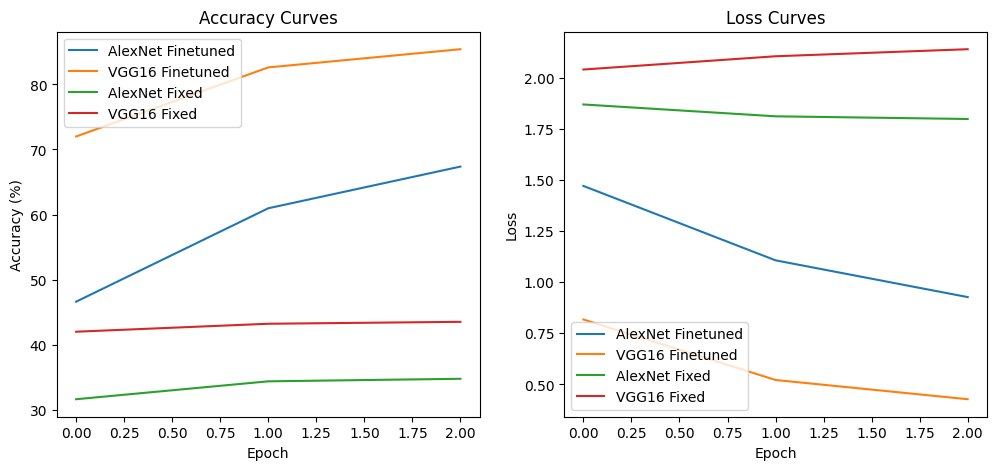

In [9]:
plot_curves(accuracy_dict, loss_dict)

1. **Accuracy Curves (Left Plot)**
* AlexNet Finetuned (Blue Line):
  * Starts with an accuracy of about 40%.
  * Shows a steady increase in accuracy across the epochs.
  * Ends with an accuracy of around 60%.
* VGG16 Finetuned (Orange Line):

  * Starts with an accuracy of around 70%.
  * Shows a significant increase in accuracy, ending at about 90%.
  * Demonstrates the highest accuracy among the models.

* AlexNet Fixed (Green Line):

  * Starts with an accuracy slightly above 30%.
  * Shows a slight increase in accuracy across epochs.
  * Ends with an accuracy below 40%.
  * Displays the lowest accuracy among the models.

* VGG16 Fixed (Red Line):

  * Starts with an accuracy of around 40%.
  * Shows a minimal increase in accuracy across epochs.
  * Ends with an accuracy around 45%.

2. **Loss Curves (Right Plot)**

* AlexNet Finetuned (Blue Line):
  * Starts with a loss slightly above 1.5.
  * Shows a consistent decrease in loss over the epochs.
  * Ends with a loss below 1.0.

* VGG16 Finetuned (Orange Line):

  * Starts with a loss slightly below 0.75.
  * Shows a consistent decrease in loss over the epochs.
  * Ends with a loss below 0.5.
  * Demonstrates the lowest loss among the models.
* AlexNet Fixed (Green Line):

  * Starts with a loss around 2.0.
  * Shows a slight decrease in loss over the epochs.
  * Ends with a loss slightly above 1.75.

* VGG16 Fixed (Red Line):

  * Starts with a loss slightly above 2.0.
  * Shows a consistent but slight increase in loss over the epochs.
  * Ends with a loss around 2.25.
  * Displays the highest loss among the models.



In conclusion, fine-tuning the pre-trained models (AlexNet and VGG16) yields better performance compared to using them as fixed feature extractors. VGG16, in particular, shows superior performance when fine-tuned.